In [ ]:
library(mlr3verse)
library(mlr3tuning)

## Solution 2: AutoML

### a)

In [25]:
#| label: 2-a
(task <- tsk("pima"))

<TaskClassif:pima> (768 x 9): Pima Indian Diabetes
* Target: diabetes
* Properties: twoclass
* Features (8):
  - dbl (8): age, glucose, insulin, mass, pedigree, pregnant, pressure,
    triceps

### b)

In [ ]:
#| label: 2-b
learners <- list(
    po(lrn("classif.kknn", id = "kknn")),
    po(lrn("classif.ranger", id = "ranger"))
)

### c)

In [27]:
#| label: 2-c
# Create a pipeline with preprocessing steps
ppl_preproc <- ppl("robustify", task = task, factors_to_numeric = TRUE)

### d)

In [28]:
#|label: 2-d
ppl_learners <- ppl("branch", learners)

### e)

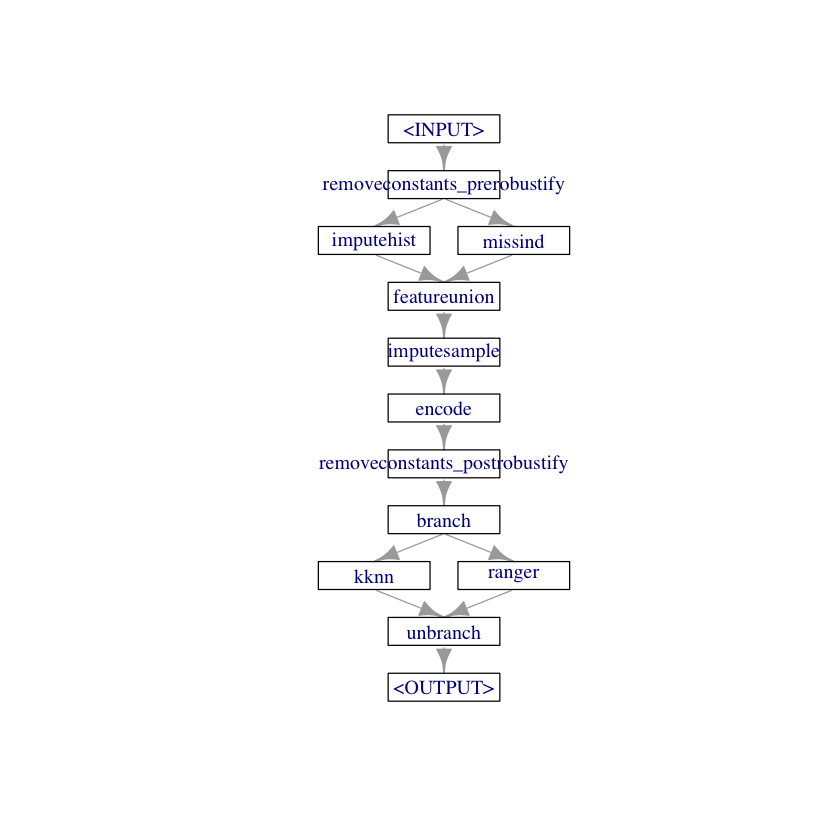

In [29]:
#| label: 2-e
ppl_combined <- ppl_preproc %>>% ppl_learners
plot(ppl_combined)
graph_learner <- as_learner(ppl_combined)

### f)

In [ ]:
#| label: 2-f
# check available hyperparameters for tuning (converting to data.table for
# better readability)
tail(as.data.table(graph_learner$param_set), 10)

# seeing all our hyperparameters of interest are of type int, we specify the
# tuning objects accordingly, and dependencies for k and mtry
graph_learner$param_set$values$branch.selection <-
  to_tune(p_int(1, 2))
graph_learner$param_set$values$kknn.k <-
  to_tune(p_int(3, 10, depends = branch.selection == 1))
graph_learner$param_set$values$ranger.mtry <-
  to_tune(p_int(1, 5, depends = branch.selection == 2))

# rename learner (otherwise, mlr3 will display a lengthy chain of operations
# in result tables)
graph_learner$id <- "graph_learner"

id,class,lower,upper,levels,nlevels,is_bounded,special_vals,default,storage_type,tags
<chr>,<chr>,<dbl>,<dbl>,<list>,<dbl>,<lgl>,<list>,<list>,<chr>,<list>
ranger.sample.fraction,ParamDbl,0,1,NULL,Inf,TRUE,NULL,<environment: 0x162f09158>,numeric,train
ranger.save.memory,ParamLgl,NA,NA,"TRUE, FALSE",2,TRUE,NULL,FALSE,logical,train
ranger.scale.permutation.importance,ParamLgl,NA,NA,"TRUE, FALSE",2,TRUE,NULL,FALSE,logical,train
ranger.se.method,ParamFct,NA,NA,"jack , infjack",2,TRUE,NULL,infjack,character,predict
ranger.seed,ParamInt,-Inf,Inf,NULL,Inf,FALSE,NULL,NULL,integer,"train , predict"
ranger.split.select.weights,ParamUty,NA,NA,NULL,Inf,FALSE,NULL,NULL,list,train
ranger.splitrule,ParamFct,NA,NA,"gini , extratrees, hellinger",3,TRUE,NULL,gini,character,train
ranger.verbose,ParamLgl,NA,NA,"TRUE, FALSE",2,TRUE,NULL,TRUE,logical,"train , predict"
ranger.write.forest,ParamLgl,NA,NA,"TRUE, FALSE",2,TRUE,NULL,TRUE,logical,train


### g)

In [ ]:
#| label: 2-g
#| output: false

# make sure to set a seed for reproducible results
set.seed(123)

# perform nested resampling, terminating after 3 evaluations
tuner <- tnr("random_search")

rr <- tune_nested(
  tuner = tuner,
  task = task,
  learner = graph_learner,
  inner_resampling = rsmp("cv", folds = 3),
  outer_resampling = rsmp("cv", folds = 3),
  measure = msr("classif.ce"),
  term_evals = 3
)

INFO  [20:46:00.931] [mlr3] Applying learner 'graph_learner.tuned' on task 'pima' (iter 1/3)
INFO  [20:46:01.085] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerRandomSearch>' and '<TerminatorEvals> [n_evals=3, k=0]'
INFO  [20:46:01.098] [bbotk] Evaluating 1 configuration(s)
INFO  [20:46:01.141] [mlr3] Running benchmark with 3 resampling iterations
INFO  [20:46:01.146] [mlr3] Applying learner 'graph_learner' on task 'pima' (iter 1/3)
INFO  [20:46:01.494] [mlr3] Applying learner 'graph_learner' on task 'pima' (iter 2/3)
INFO  [20:46:02.050] [mlr3] Applying learner 'graph_learner' on task 'pima' (iter 3/3)
INFO  [20:46:02.387] [mlr3] Finished benchmark
INFO  [20:46:02.407] [bbotk] Result of batch 1:
INFO  [20:46:02.409] [bbotk]  kknn.k ranger.mtry branch.selection classif.ce warnings errors
INFO  [20:46:02.409] [bbotk]      NA           3                2  0.2188052        0      0
INFO  [20:46:02.409] [bbotk]  runtime_learners                                uhash
INFO  [20:

### h)

In [32]:
#| label: 2-h
rr$score()
rr$aggregate()

task,task_id,learner,learner_id,resampling,resampling_id,iteration,prediction,classif.ce
<list>,<chr>,<list>,<chr>,<list>,<chr>,<int>,<list>,<dbl>
<environment: 0x17984ce48>,pima,<environment: 0x1655992d8>,graph_learner.tuned,<environment: 0x17a5a7248>,cv,1,<environment: 0x166bceba8>,0.2695312
<environment: 0x17984ce48>,pima,<environment: 0x165789c70>,graph_learner.tuned,<environment: 0x17a5a7248>,cv,2,<environment: 0x166926e28>,0.2617188
<environment: 0x17984ce48>,pima,<environment: 0x1631c8e38>,graph_learner.tuned,<environment: 0x17a5a7248>,cv,3,<environment: 0x16e16daa8>,0.1953125


classif.ce 
 0.2421875

The performance estimate for our tuned learner then amounts to an MCE of around 0.24.

## Solution 3: Kaggle Challenge

We do not provide an explicit solution here, but have a look at the [tuning code demo](https://github.com/slds-lmu/lecture_i2ml/blob/master/code-demos-pdf/code_demo_kaggle.pdf), which is written in *mlr3* and covers some parts,
and take inspiration from the public contributions on Kaggle.